In [1]:
import os
import json
import pandas as pd

import requests
from openai import OpenAI
from datetime import date
from datetime import datetime

from dotenv import load_dotenv
import sys

import io
import base64
import urllib
from PIL import Image
import io
import cv2

from diffusers import AutoPipelineForText2Image, AutoPipelineForImage2Image # DiffusionPipeline
import torch
import matplotlib.pyplot as plt

import prompts as pr

pf_api_url = "https://graphql.probablefutures.org"
pf_token_audience = "https://graphql.probablefutures.com"
pf_token_url = "https://probablefutures.us.auth0.com/oauth/token"

load_dotenv()
client = OpenAI()

model = "gpt-4-0125-preview"  # gpt-4 #gpt-3.5-turbo-16k


pipeline_text2image = AutoPipelineForText2Image.from_pretrained("stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16")
pipeline_image2image = AutoPipelineForImage2Image.from_pretrained("stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16")
pipeline_text2image.to("cuda")
pipeline_image2image.to("cuda")

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionXLImg2ImgPipeline {
  "_class_name": "StableDiffusionXLImg2ImgPipeline",
  "_diffusers_version": "0.26.2",
  "_name_or_path": "stabilityai/sdxl-turbo",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "requires_aesthetics_score": false,
  "scheduler": [
    "diffusers",
    "EulerAncestralDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [2]:
def get_image_response_SDXL(prompt, image_path=None, filtered_keywords=None): #i'm passing a file path to image when using inpainting; FOR NOW
    print('starting SDXL')  # Check here for prompt language tips: https://stable-diffusion-art.com/sdxl-prompts/
    
    if image_path is None:
        # Generate image from text
        # using flash attention for memory optimization 
        # https://huggingface.co/docs/diffusers/en/optimization/memory#memory-efficient-attention
        #with torch.inference_mode():
        result_image = pipeline_text2image(
            prompt=prompt, num_inference_steps=2, guidance_scale=0.0).images[0]  # Assuming default image dimensions or specify if required
    else:
        # Load the image from the path
        #img = Image.open(image_path) 

        #plt.imshow(img)
        #plt.title("Loaded Image")
        #plt.show() 

        #if strength == None:
        #    strength = 0.51

        # adding inpaiting keywords for 2.0 and 3.0 warming scenarios
        modified_prompt = filtered_keywords if filtered_keywords else prompt
        print(modified_prompt)

        # Modify existing image based on new prompt
        # using flash attention https://huggingface.co/docs/diffusers/en/optimization/memory#memory-efficient-attention
        #with torch.inference_mode():
        result_image = pipeline_image2image(
            prompt=modified_prompt, image=image_path, strength=0.4, guidance_scale=0.0, num_inference_steps=2).images[0]  # negative_prompt="deformed faces, distorted faces, mangled hands, extra legs", 

    # Save the image to a byte buffer
    buffer = io.BytesIO()
    result_image.save(buffer, format='PNG')
    image_bytes = buffer.getvalue()
    return result_image, image_bytes 

In [23]:
test_prompt = 'the city of denver colorado on a beautiful spring day'
inpaiting_kws = 'extreme drought and hazy air'

In [24]:
image_content, image_bytes = get_image_response_SDXL(test_prompt)

starting SDXL


  0%|          | 0/2 [00:00<?, ?it/s]

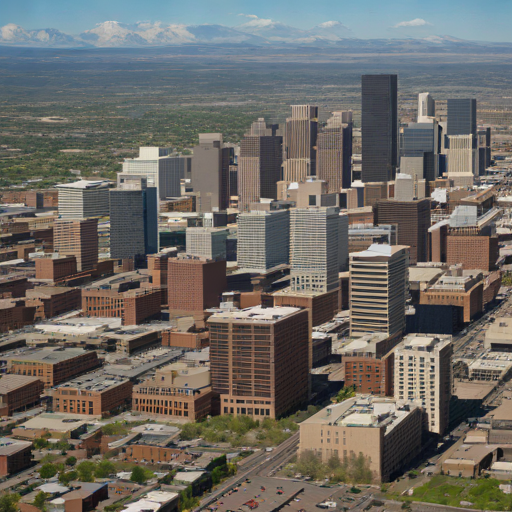

In [25]:
image_content

In [26]:
image_content.size

(512, 512)

In [27]:
type(image_content)

PIL.Image.Image

In [31]:
new_image = pipeline_image2image(prompt=inpaiting_kws, image=image_content, strength=0.5, guidance_scale=0.0, num_inference_steps=2).images[0]

  0%|          | 0/1 [00:00<?, ?it/s]

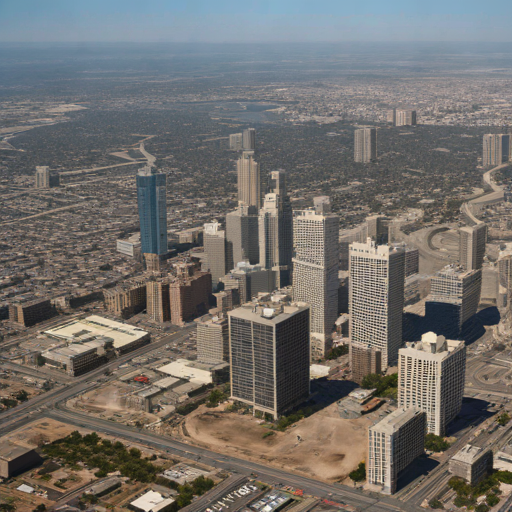

In [32]:
new_image

In [11]:
import torch
from PIL import Image
import torchvision.transforms as transforms

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/system/conda/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [33]:
result_image = pipeline_image2image(prompt=inpaiting_kws, image=image_content, strength=0.5, guidance_scale=0.0, num_inference_steps=2).images[0]  # negative_prompt="deformed faces, distorted faces, mangled hands, extra legs", 


  0%|          | 0/1 [00:00<?, ?it/s]

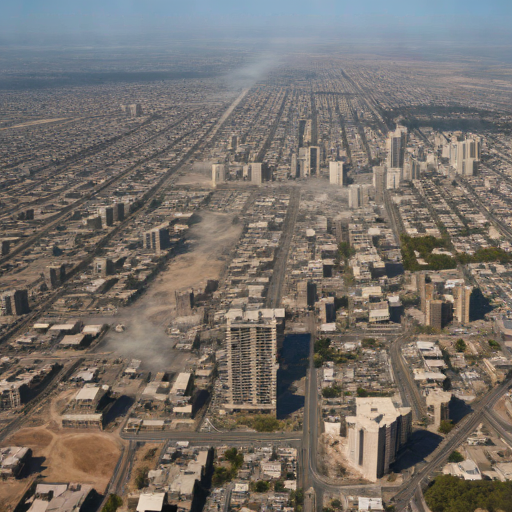

In [34]:
result_image

In [12]:
# https://www.tutorialspoint.com/how-to-convert-an-image-to-a-pytorch-tensor
transform = transforms.ToTensor()

# Convert the image to PyTorch tensor
tensor = transform(image_content)

In [15]:
tensor.shape

torch.Size([3, 512, 512])

In [14]:
new_image_content, new_image_bytes = get_image_response_SDXL(prompt=test_prompt, image_path=tensor, filtered_keywords=inpaiting_kws)

starting SDXL
extreme drought and hazy air


0it [00:00, ?it/s]

RuntimeError: cannot reshape tensor of 0 elements into shape [0, -1, 1, 512] because the unspecified dimension size -1 can be any value and is ambiguous